In [26]:
import os
import numpy as np
from PIL import Image
import pandas as pd

bird_dir = "/Users/egormaksimov/Documents/PROGRAMMING/ML/drone_vs_bird_classification/drone_or_bird/birds"
drone_dir = "/Users/egormaksimov/Documents/PROGRAMMING/ML/drone_vs_bird_classification/drone_or_bird/drones"
IMG_SIZE = (128, 128)

data = []


def process_images(directory, label):
    counter = 0
    print("total N on files: ", len(os.listdir(directory)))
    for file in os.listdir(directory):
        if file.endswith((".jpg", ".png", ".jpeg", ".JPEG")):
            img_path = os.path.join(directory, file)
            img = Image.open(img_path).convert("RGB")
            img = img.resize(IMG_SIZE)
            img_array = np.array(img, dtype=np.float32)
            img_array = img_array / 255.0
            img_array = img_array.flatten()
            img_array = np.append(img_array, label)
            data.append(img_array)
            counter += 1
        else:
            print(f"skipped: {file}")

    print("skips:", len(os.listdir(directory)) - counter)


process_images(bird_dir, 0)
process_images(drone_dir, 1)

data = np.array(data)

df = pd.DataFrame(data)
df.to_csv("image_data_normalized.csv", index=False)

print("Dataset saved as image_data_normalized.csv")

total N on files:  400
skips: 0
total N on files:  428
skips: 0
Dataset saved as image_data_normalized.csv


In [27]:
import pandas as pd
import numpy as np
from PIL import Image

data = pd.read_csv("image_data_normalized.csv")

data.shape

(828, 49153)

In [28]:
data.shape

(828, 49153)

In [29]:
class Conv2D:

    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        learning_rate=0.001,
    ):
        self.in_channels = 3
        self.out_channels = 32
        self.lr = learning_rate

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.num_filters = 32

        self.W1 = np.random.rand(32, 3, 3, 3) * 0.1
        self.b1 = np.zeros(32)

        self.W2 = np.random.randn(64, 3, 3, 32) * 0.1
        self.b2 = np.zeros(64)

        self.W3 = np.random.randn(128, 3, 3, 64) * 0.1
        self.b3 = np.zeros(128)

        self.W4 = np.random.randn(512, 128 * 16 * 16) * 0.01
        self.b4 = np.zeros(512)

        self.W5 = np.random.randn(1, 512) * 0.01
        self.b5 = np.zeros(1)

    def ReLU(self, Z):
        return np.maximum(0, Z)

    def ReLU_deriv(self, Z):
        return (Z > 0).astype(float)

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def convolution(self, X, weights, biases):
        X_h, X_w, _ = X.shape

        padding_size = self.padding
        stride = self.stride
        kernel_size = self.kernel_size

        out_height = (X_h + 2 * padding_size - kernel_size) // stride + 1
        out_width = (X_w + 2 * padding_size - kernel_size) // stride + 1

        output = np.zeros((out_height, out_width, weights.shape[0]))

        X_padded = np.pad(
            X,
            pad_width=(
                (padding_size, padding_size),
                (padding_size, padding_size),
                (0, 0),
            ),
            mode="constant",
            constant_values=0,
        )

        for i in range(out_height):
            for j in range(out_width):
                patch = X_padded[
                    i * stride : i * stride + kernel_size,
                    j * stride : j * stride + kernel_size,
                    :,
                ]
                number_of_features = weights.shape[0]
                for k in range(number_of_features):
                    conv_result = np.sum(patch * weights[k]) + biases[k]
                    output[i, j, k] = conv_result

        return self.ReLU(output)

    def max_pool(self, X, pool_size=2, pool_stride=2):
        X_h, X_w, X_ch = X.shape

        out_height = (X_h - pool_size) // pool_stride + 1
        out_width = (X_w - pool_size) // pool_stride + 1
        out_channels = X_ch

        pool_output = np.zeros((out_height, out_width, out_channels))

        for c in range(out_channels):
            for i in range(out_height):
                for j in range(out_width):
                    h_start = i * pool_stride
                    h_end = h_start + pool_size
                    w_start = j * pool_stride
                    w_end = w_start + pool_size

                    region = X[h_start:h_end, w_start:w_end, c]

                    pool_output[i, j, c] = np.max(region)

        return pool_output

    def flatten(self, X):
        return X.reshape(-1)

    def fully_connected(self, X, weights, biases, apply_relu=True):
        output = weights @ X + biases
        if apply_relu:
            return self.ReLU(output)
        return output

    def forward(self, X):
        self.X = X
        self.conv1 = self.convolution(X, self.W1, self.b1)
        self.pool1 = self.max_pool(self.conv1)

        self.conv2 = self.convolution(self.pool1, self.W2, self.b2)
        self.pool2 = self.max_pool(self.conv2)

        self.conv3 = self.convolution(self.pool2, self.W3, self.b3)
        self.pool3 = self.max_pool(self.conv3)

        self.flat = self.flatten(self.pool3)

        self.fc1_z = self.fully_connected(self.flat, self.W4, self.b4, apply_relu=False)
        self.fc1 = self.ReLU(self.fc1_z)

        self.fc2_z = self.fully_connected(self.fc1, self.W5, self.b5, apply_relu=False)
        self.fc2 = self.sigmoid(self.fc2_z)

        return self.fc2

    def backward(self, y):
        dZ5 = self.fc2 - y

        dW5 = dZ5 * self.fc1.T
        db5 = dZ5

        dA4 = self.W5.T @ dZ5
        dZ4 = dA4 * self.ReLU_deriv(self.fc1_z)

        dW4 = dZ4[:, np.newaxis] @ self.flat[np.newaxis, :]
        db4 = dZ4

        dflat = self.W4.T @ dZ4
        dpool3 = dflat.reshape(16, 16, 128)
        dconv3 = np.zeros_like(self.conv3)
        for c in range(128):
            for i in range(16):
                for j in range(16):
                    h_start = i * 2
                    w_start = j * 2
                    region = self.conv3[h_start : h_start + 2, w_start : w_start + 2, c]
                    max_idx = np.argmax(region)
                    dconv3[h_start + max_idx // 2, w_start + max_idx % 2, c] = dpool3[
                        i, j, c
                    ]

        dW3 = np.zeros_like(self.W3)
        db3 = np.zeros_like(self.b3)
        dpool2 = np.zeros_like(self.pool2)
        conv3_padded = np.pad(self.pool2, ((1, 1), (1, 1), (0, 0)), mode="constant")
        for i in range(32):
            for j in range(32):
                patch = conv3_padded[i : i + 3, j : j + 3, :]
                for k in range(128):
                    dW3[k] += patch * dconv3[i, j, k]
                    db3[k] += dconv3[i, j, k]
                dpool2[i, j, :] += np.sum(
                    self.W3 * dconv3[i, j, :, np.newaxis, np.newaxis, np.newaxis],
                    axis=(0, 1, 2),
                )

        dconv2 = np.zeros_like(self.conv2)
        for c in range(64):
            for i in range(32):
                for j in range(32):
                    h_start = i * 2
                    w_start = j * 2
                    region = self.conv2[h_start : h_start + 2, w_start : w_start + 2, c]
                    max_idx = np.argmax(region)
                    dconv2[h_start + max_idx // 2, w_start + max_idx % 2, c] = dpool2[
                        i, j, c
                    ]

        dW2 = np.zeros_like(self.W2)
        db2 = np.zeros_like(self.b2)
        dpool1 = np.zeros_like(self.pool1)
        conv2_padded = np.pad(self.pool1, ((1, 1), (1, 1), (0, 0)), mode="constant")
        for i in range(64):
            for j in range(64):
                patch = conv2_padded[i : i + 3, j : j + 3, :]
                for k in range(64):
                    dW2[k] += patch * dconv2[i, j, k]
                    db2[k] += dconv2[i, j, k]
                dpool1[i, j, :] += np.sum(
                    self.W2 * dconv2[i, j, :, np.newaxis, np.newaxis, np.newaxis],
                    axis=(0, 1, 2),
                )

        dconv1 = np.zeros_like(self.conv1)
        for c in range(32):
            for i in range(64):
                for j in range(64):
                    h_start = i * 2
                    w_start = j * 2
                    region = self.conv1[h_start : h_start + 2, w_start : w_start + 2, c]
                    max_idx = np.argmax(region)
                    dconv1[h_start + max_idx // 2, w_start + max_idx % 2, c] = dpool1[
                        i, j, c
                    ]

        dW1 = np.zeros_like(self.W1)
        db1 = np.zeros_like(self.b1)
        X_padded = np.pad(self.X, ((1, 1), (1, 1), (0, 0)), mode="constant")
        for i in range(128):
            for j in range(128):
                patch = X_padded[i : i + 3, j : j + 3, :]
                for k in range(32):
                    dW1[k] += patch * dconv1[i, j, k]
                    db1[k] += dconv1[i, j, k]

        self.W5 -= self.lr * dW5
        self.b5 -= self.lr * db5
        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, y, epochs=10):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = -(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))
            print(f"Epoch {epoch+1}, Loss: {loss}")
            self.backward(y)

In [30]:
import matplotlib.pyplot as plt


def draw_per_image_loss_and_accuracy(
    fig_image, ax1_image, ax2_image, count, epoch, image_losses, image_accuracies
):
    image_counts = np.arange(1, count + 1)
    ax1_image.clear()
    ax2_image.clear()

    ax1_image.plot(image_counts, image_losses, "go-", label="Loss")
    ax1_image.set_xlabel("Image Count")
    ax1_image.set_ylabel("Loss")
    ax1_image.set_title(f"Loss per Image (Epoch {epoch+1})")
    ax1_image.grid(True)
    ax1_image.legend()

    ax2_image.plot(image_counts, image_accuracies, "bo-", label="Accuracy")
    ax2_image.set_xlabel("Image Count")
    ax2_image.set_ylabel("Accuracy (%)")
    ax2_image.set_title(f"Accuracy per Image (Epoch {epoch+1})")
    ax2_image.grid(True)
    ax2_image.legend()

    plt.tight_layout()
    fig_image.canvas.draw()
    fig_image.canvas.flush_events()
    plt.savefig(f"image_progress_epoch_{epoch+1}.png", dpi=100)


def draw_per_epoch_loss_and_accuracy(
    fig_epoch, ax1_epoch, ax2_epoch, epoch, epoch_losses, epoch_accuracies
):
    epochs_so_far = np.arange(1, epoch + 2)
    ax1_epoch.clear()
    ax2_epoch.clear()

    ax1_epoch.plot(epochs_so_far, epoch_losses, "go-", label="Loss")
    ax1_epoch.set_xlabel("Epoch")
    ax1_epoch.set_ylabel("Average Loss")
    ax1_epoch.set_title("Loss per Epoch")
    ax1_epoch.grid(True)
    ax1_epoch.legend()

    ax2_epoch.plot(epochs_so_far, epoch_accuracies, "bo-", label="Accuracy")
    ax2_epoch.set_xlabel("Epoch")
    ax2_epoch.set_ylabel("Accuracy (%)")
    ax2_epoch.set_title("Accuracy per Epoch")
    ax2_epoch.grid(True)
    ax2_epoch.legend()

    plt.tight_layout()
    fig_epoch.canvas.draw()
    fig_epoch.canvas.flush_events()
    plt.savefig("training_progress.png", dpi=100)

num_samples:  828
Total training set:  662
Processing image number: 1/662
Current Loss: [0.49570059], ETA: 10h 34m 9s. Accuracy: 100.0. Confidence: [21.82879906]%.
Processing image number: 2/662
Current Loss: [0.70044554], ETA: 10h 24m 40s. Accuracy: 50.0. Confidence: [0.72717952]%.
Processing image number: 3/662
Current Loss: [0.58770205], ETA: 10h 18m 55s. Accuracy: 66.66666666666667. Confidence: [11.12051361]%.
Processing image number: 4/662
Current Loss: [0.69677007], ETA: 10h 21m 19s. Accuracy: 50.0. Confidence: [0.36163352]%.
Processing image number: 5/662
Current Loss: [0.69343413], ETA: 10h 25m 5s. Accuracy: 40.0. Confidence: [0.02869095]%.
Processing image number: 6/662
Current Loss: [0.73379931], ETA: 10h 21m 43s. Accuracy: 33.333333333333336. Confidence: [3.98369144]%.
Processing image number: 7/662
Current Loss: [0.89244937], ETA: 10h 19m 57s. Accuracy: 28.571428571428573. Confidence: [18.06977325]%.
Processing image number: 8/662
Current Loss: [0.70058981], ETA: 10h 20m 35

/var/folders/0g/cbzx8x4551vc_x1pjm9yp9140000gn/T/ipykernel_5739/2438018272.py:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


Current Loss: [34.53877639], ETA: 3h 17m 5s. Accuracy: 67.78242677824268. Confidence: [100.]%.
Processing image number: 479/662
Current Loss: [-1.11022302e-15], ETA: 3h 16m 59s. Accuracy: 67.84968684759916. Confidence: [100.]%.
Processing image number: 480/662
Current Loss: [-1.11022302e-15], ETA: 3h 16m 53s. Accuracy: 67.91666666666667. Confidence: [100.]%.
Processing image number: 481/662
Current Loss: [34.53877639], ETA: 3h 16m 48s. Accuracy: 67.77546777546777. Confidence: [100.]%.
Processing image number: 482/662
Current Loss: [34.53877639], ETA: 3h 16m 42s. Accuracy: 67.63485477178423. Confidence: [100.]%.
Processing image number: 483/662
Current Loss: [34.53877639], ETA: 3h 16m 37s. Accuracy: 67.49482401656314. Confidence: [100.]%.
Processing image number: 484/662


/var/folders/0g/cbzx8x4551vc_x1pjm9yp9140000gn/T/ipykernel_5739/2438018272.py:77: RuntimeWarning: overflow encountered in multiply
  conv_result = np.sum(patch * weights[k]) + biases[k]
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/0g/cbzx8x4551vc_x1pjm9yp9140000gn/T/ipykernel_5739/2438018272.py:109: RuntimeWarning: invalid value encountered in matmul
  output = weights @ X + biases


Current Loss: [nan], ETA: 3h 16m 31s. Accuracy: 67.56198347107438. Confidence: [nan]%.
Processing image number: 485/662
Current Loss: [nan], ETA: 3h 16m 26s. Accuracy: 67.62886597938144. Confidence: [nan]%.
Processing image number: 486/662
Current Loss: [nan], ETA: 3h 16m 20s. Accuracy: 67.48971193415638. Confidence: [nan]%.
Processing image number: 487/662
Current Loss: [nan], ETA: 3h 16m 15s. Accuracy: 67.5564681724846. Confidence: [nan]%.
Processing image number: 488/662
Current Loss: [nan], ETA: 3h 16m 9s. Accuracy: 67.62295081967213. Confidence: [nan]%.
Processing image number: 489/662
Current Loss: [nan], ETA: 3h 16m 4s. Accuracy: 67.68916155419222. Confidence: [nan]%.
Processing image number: 490/662
Current Loss: [nan], ETA: 3h 15m 58s. Accuracy: 67.75510204081633. Confidence: [nan]%.
Processing image number: 491/662
Current Loss: [nan], ETA: 3h 15m 53s. Accuracy: 67.61710794297352. Confidence: [nan]%.
Processing image number: 492/662
Current Loss: [nan], ETA: 3h 15m 47s. Accur

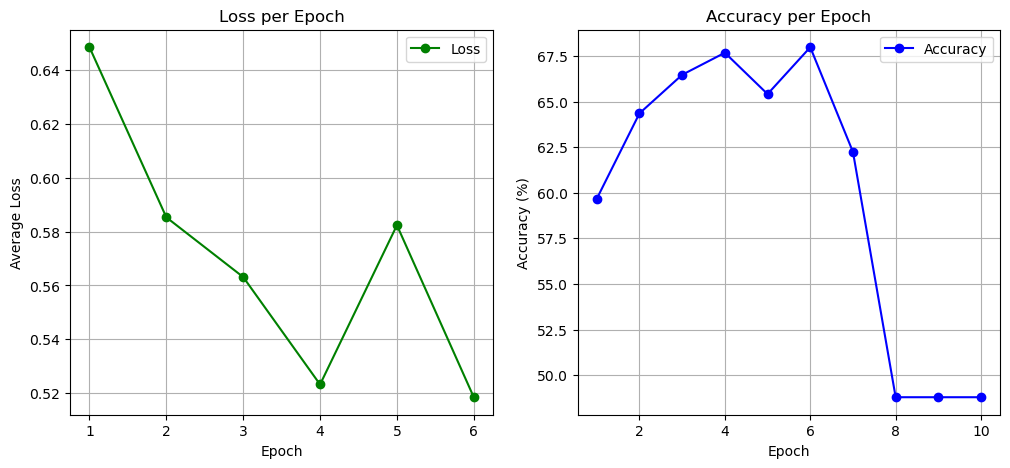

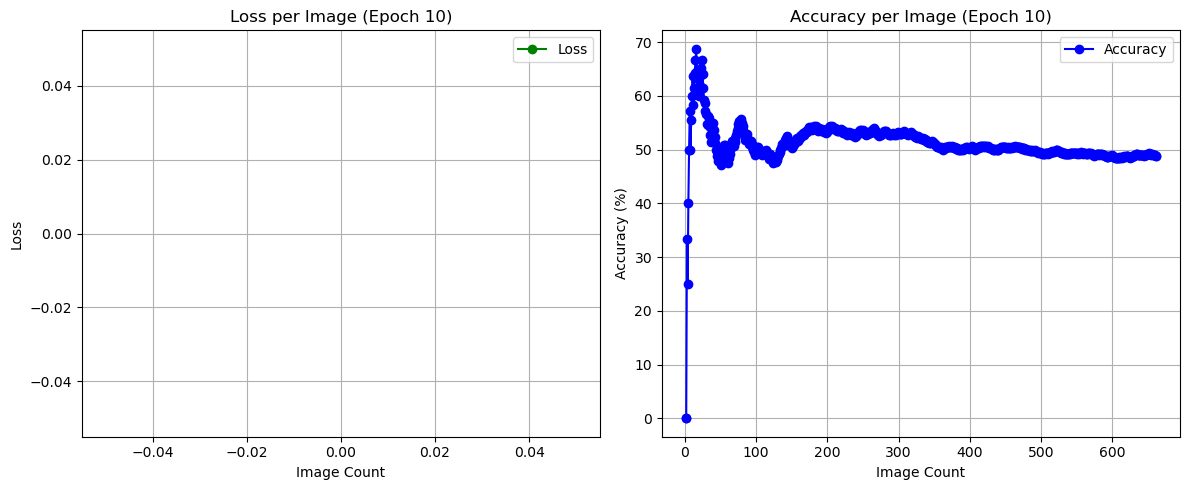

([array([0.64857233]),
  array([0.58532927]),
  array([0.56312868]),
  array([0.52319399]),
  array([0.58239381]),
  array([0.5184568]),
  array([nan]),
  array([nan]),
  array([nan]),
  array([nan])],
 [59.66767371601208,
  64.35045317220543,
  66.46525679758308,
  67.6737160120846,
  65.40785498489426,
  67.97583081570997,
  62.235649546827794,
  48.79154078549849,
  48.79154078549849,
  48.79154078549849])

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
)
import time

num_samples = len(data)
print("num_samples: ", num_samples)
images = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

images = np.array(images, dtype=np.uint8).reshape(num_samples, 128, 128, 3)
labels = np.array(labels, dtype=np.float32)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, shuffle=True
)

cnn = Conv2D(padding=1, stride=1, learning_rate=0.01)


print("Total training set: ", len(train_images))


def show_time(count, epoch, start_time, num_train, epochs, loss, accuracy, confidence):
    elapsed_time = time.time() - start_time
    images_processed = count
    time_per_image = elapsed_time / images_processed
    remaining_images = num_train - count + (epochs - (epoch + 1)) * num_train
    eta_seconds = time_per_image * remaining_images

    eta_h = int(eta_seconds // 3600)
    eta_m = int((eta_seconds % 3600) // 60)
    eta_s = int(eta_seconds % 60)
    eta_str = f"ETA: {eta_h}h {eta_m}m {eta_s}s"

    print(
        f"Current Loss: {loss}, {eta_str}. Accuracy: {accuracy}. Confidence: {confidence}%."
    )


def train_model(cnn, train_images, train_labels, epochs=1):
    num_train = len(train_images)

    epoch_losses = []
    epoch_accuracies = []

    plt.ion()

    fig_epoch, (ax1_epoch, ax2_epoch) = plt.subplots(1, 2, figsize=(12, 5))
    fig_image, (ax1_image, ax2_image) = plt.subplots(1, 2, figsize=(12, 5))

    for epoch in range(epochs):
        total_loss = 0
        indices = np.random.permutation(num_train)
        count = 1
        start_time = time.time()
        total = 0
        total_accurate = 0

        image_losses = []
        image_accuracies = []

        for i in indices:
            print(f"Processing image number: {count}/{num_train}")

            X = train_images[i]
            y = train_labels[i]

            y_pred = cnn.forward(X)
            loss = -(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))
            total_loss += loss
            image_losses.append(loss)

            total += 1
            pred_label = 1 if y_pred >= 0.5 else 0
            total_accurate += 1 if pred_label == y else 0
            accuracy = 100 * total_accurate / total if total > 0 else 0
            image_accuracies.append(accuracy)
            confidence = 200 * abs(y_pred - 0.5)

            cnn.backward(y)

            draw_per_image_loss_and_accuracy(
                fig_image,
                ax1_image,
                ax2_image,
                count,
                epoch,
                image_losses,
                image_accuracies,
            )

            show_time(
                count, epoch, start_time, num_train, epochs, loss, accuracy, confidence
            )
            count += 1

        avg_loss = total_loss / num_train
        avg_accuracy = 100 * total_accurate / num_train
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(avg_accuracy)

        print(
            f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Average Accuracy: {avg_accuracy}%"
        )
        print("-" * 50)

        draw_per_epoch_loss_and_accuracy(
            fig_epoch, ax1_epoch, ax2_epoch, epoch, epoch_losses, epoch_accuracies
        )

    plt.ioff()
    plt.show()

    return epoch_losses, epoch_accuracies


train_model(cnn, train_images, train_labels, epochs=10)

In [32]:
def evaluate_model(cnn, test_images, test_labels):
    num_test = len(test_images)
    print("num_test: ", num_test)
    correct = 0
    for i in range(num_test):
        X = test_images[i]
        y = test_labels[i]
        y_pred = cnn.forward(X)
        print(
            f"Expected: {'bird' if y == 0 else 'dron'}\nActual: {'bird' if y_pred == 0 else 'dron'}\n\n"
        )
        predicted_label = 1 if y_pred > 0.5 else 0
        if predicted_label == y:
            correct += 1
    accuracy = correct / num_test
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


evaluate_model(cnn, test_images, test_labels)

num_test:  166
Expected: dron
Actual: dron


Expected: dron
Actual: dron


Expected: bird
Actual: dron


Expected: dron
Actual: dron


Expected: bird
Actual: dron


Expected: dron
Actual: dron


Expected: dron
Actual: dron


Expected: bird
Actual: dron


Expected: bird
Actual: dron


Expected: dron
Actual: dron


Expected: dron
Actual: dron


Expected: bird
Actual: dron


Expected: bird
Actual: dron


Expected: bird
Actual: dron


Expected: bird
Actual: dron


Expected: bird
Actual: dron


Expected: bird
Actual: dron


Expected: bird
Actual: dron


Expected: dron
Actual: dron


Expected: dron
Actual: dron


Expected: dron
Actual: dron


Expected: bird
Actual: dron


Expected: bird
Actual: dron


Expected: dron
Actual: dron


Expected: bird
Actual: dron


Expected: dron
Actual: dron


Expected: bird
Actual: dron


Expected: dron
Actual: dron


Expected: dron
Actual: dron


Expected: bird
Actual: dron


Expected: bird
Actual: dron


Expected: bird
Actual: dron


Expected: bird
Actual: dr

In [ ]:
print(f"Epoch {1+1}/{1}, Average Loss: {12}, " f"Average Accuracy: {2}%")

Epoch 2/1, Average Loss: 12, Average Accuracy: 2%
